In this section we will introduce some basics to supervised learning. As opposed to the last section on unsupervised learning where we did not know exactly what we were looking for or know what was the correct answer. In supervised learning we have a clear objective with a measurable outcome. 

In supervised learning the goal is often to use our biological data to predict some additional property about the sample such as a phenotype (e.g. healthy v. sick) based on genotype data (e.g. gene abundance). When the additional property is categorical (e.g. health v. sick) supervised learning is called `classification`. When the additional property is continuous such as (e.g. blood pressure)  supervised learning is called `regression`.


Supervised learning learns the `rules` in a training data to predict the additional property of the data. These `rules` can be used to predict the unknown or better understand biology. 

There are almost countless different methods in supervised learning and each modeling method has different strengths and weaknesses. However, the basic components of training a model to learn the `rules` is shared between the different methods:


1.	Data type exploration (often unsupervised learning)
2.	Choose model class decision 
3.	Choose preset model parameters (hyperparameters)
4.	Fit the model to the training data
5.	Use the model to predict labels for new or holdout data


Rather than focus on the many different classes of model we will focus on the recipe for modeling above. Note that the optimal model class is often a well explored subject in different sub-disciplines within biology but also a constantly evolving topic. It always recommended to do a deep dive on prior literature in your sub discipline before approaching the training of a certain model. There also great free resources online for exploring different model classes and the method behind them. 

In order to explore this protocol for model training and evaluation we will continue our example from the unsupervised learning section. First we will import the data.




In [1]:
import numpy as np
import pandas as pd
from biom import Table, load_table

In [2]:
# import sample metadata
mf = pd.read_csv('data/general-unsupervised-learning/232_20170409-171325.txt',
                 sep='\t', index_col=0)
# keep only the three subjects (for example)
mf = mf[mf.host_subject_id.isin(['M2','M3','M9'])]
mf['body_habitat'] = mf.body_habitat.replace({'Not applicable':'keyboard',
                                              'UBERON:skin':'human skin'})
# import table and filter
bt = load_table('data/general-unsupervised-learning/46811_otu_table.biom')
bt = bt.filter(mf.index)
bt = bt.filter(bt.ids('observation')[bt.sum('observation') > 10],
               'observation')
# convert to dataframe (for tutorial)
table = pd.DataFrame(bt.matrix_data.toarray(),
                     bt.ids('observation'), bt.ids())
table.head(5)

,232.M3Rinl217,232.M2Fkey217,232.M2Pkey217,232.M2Dkey217,232.M2Akey217,232.M2Bkey217,232.M2Ekey217,232.M2Enter217,232.M2Gkey217,232.M2Hkey217,...,232.M3Thml217,232.M2Ckey217,232.M2Zkey217,232.M2Midl217,232.M2Rinr217,232.M2Thml217,232.M2Wkey217,232.M3Xkey217,232.M3Ekey217,232.M3Kkey217
410908,0.0,7.0,7.0,0.0,1.0,3.0,1.0,26.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389067,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
981783,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196271,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4465746,0.0,10.0,11.0,22.0,19.0,24.0,16.0,26.0,17.0,9.0,...,0.0,21.0,6.0,11.0,6.0,9.0,12.0,0.0,0.0,0.0


In [3]:
mf[['host_subject_id','body_habitat']].head(5)

,host_subject_id,body_habitat
sample_name,,
232.M2Akey217,M2,keyboard
232.M2Bkey217,M2,keyboard
232.M2Ckey217,M2,keyboard
232.M2Dkey217,M2,keyboard
232.M2Ekey217,M2,keyboard


The *table* contains microbes in the rows and samples in the columns where entries are the number of sequences counted for the microbes in each sample. Additionally, the *mf* dataframe contains information for each sample in the *table* columns such as which subject the keys are known to be matched to. From the unsupervised analysis we know that the samples separate by which person they came from ("host_subject_id") and if the sample originated from a keyboard or the persons skin ("body_habitat"). For our supervised analysis we will try to predict from the keyboard samples which person the transferred microbiome on the keys originated. 

Using pandas we can see we have 3 subjects with 10 skin samples (10 digits) and between 21-30 keyboard samples.  


In [4]:
count_subjects_samples = {k:df.body_habitat.value_counts()
                          for k, df in mf.groupby('host_subject_id')}
count_subjects_samples


{'M2': keyboard      30
 human skin    10
 Name: body_habitat, dtype: int64, 'M3': keyboard      23
 human skin    10
 Name: body_habitat, dtype: int64, 'M9': keyboard      21
 human skin    10
 Name: body_habitat, dtype: int64}

Now we will talk about model validation, where after choosing a model and hyperparameters for our data, we verify our model is fit well (i.e. can predict accurately). Two core issues inherent to this validation are `overfitting` and `generalizability`. To explore these topics, we will take a naive first approach and learn on all of our data. To do this we will use k nearest neighbors (KNN) classifier with n_neighbors=1. This simple model just assumes the label of an “unknown” data point as the same as the closest trained data. 

In [5]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Now we will train the model on all of the data to predict the subject (which we already know).  

In [6]:
X = table.values.T
y = mf['host_subject_id'].values
model.fit(X, y)
y_model = model.predict(X)

Next we will look at the fraction of correctly classified points.

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We can see now that we have a 100% accuracy classifier! Now we can publish a paper saying we can now identify if someone touched a computer by their microbiome, a likely useful application for forensics. But are we really measuring the expected accuracy? and are we confident that we would identify the right person 100% of the time?

No!! This approach has many flaws including the model is trained and evaluated on the same data (and not answering our original question) and the model class and parameters we chose will simply store our data and predict 100% in every case. 

In order to combat this problem, we will use a holdout set. This means we will take part of our data to train the model and hide another part of our data to test the model. 


In [8]:
from sklearn.model_selection import train_test_split

# specify the model (default)
model = KNeighborsClassifier()

# split data 50% train and 50% test
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on only training set (X1, y1)
model.fit(X1, y1)

# evaluate on only the test set (X2, y2)
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.7115384615384616

We also still have a problem. We are not really using all of our data because 50% will be used to train and 50% to test, we will only really use 50%. To combat this, we will use ` cross-validation` where we will switch the train and test sets in two iterations. 

In [9]:
# predict using org. train/test
y2_model = model.fit(X1, y1).predict(X2)
# now swtich test to train
y1_model = model.fit(X2, y2).predict(X1)
# explore the accruacy of both
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.4807692307692308, 0.7115384615384616)

This is called two-fold validation. We can do 5-fold cross-validation by using smaller holdouts and switching the train/test set multiple times. 

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.59090909, 0.52380952, 0.57142857, 0.6       , 0.25      ])

The most iterations possible is the total number of samples, where the model is trained on all but one holdout sample. This method is called leave-one-out cross validation.

In [11]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(X)
scores = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_model = model.fit(X_train, y_train).predict(X_test)
    scores.append(accuracy_score(y_test, y_model))
len(scores)


104

In [12]:
np.mean(scores)


0.5769230769230769

Now in our case we would like to ask a question with the way we create holdouts. Can we predict the person (based on skin microbiome samples) who touched the keyboard (based on keyboard microbiome samples)? So we will make our test set only skin samples (one sample for each digit) and the test set the keyboard samples.

In [13]:
# get test set
test_samples = mf[mf.body_habitat == 'keyboard'].index
X_test = table.loc[:, test_samples].values.T
y_test = mf.loc[test_samples, 'host_subject_id'].values
# get train set
train_samples = mf[mf.body_habitat == 'human skin'].index
X_train = table.loc[:, train_samples].values.T
y_train = mf.loc[train_samples, 'host_subject_id'].values
# predict using train/test
y_model = model.fit(X_train, y_train).predict(X_test)
# explore the accruacy of the mdoel
accuracy_score(y_test, y_model)


0.7567567567567568

Now we can see that we can predict with ~76% accuracy the person who touched the keyboard through their microbiome!

The next step in improving this is hyperparameter optimization. By optimization of hyperparameters we hope to gain a better model fit to the data and therefor prediction. However, we first need to address to core issues with the protocol we just explored being `overfitting` and `generalizability`. Overfitting is the act of altering our model or hyperparameters such that they fit our collected data perfectly but do not generalize to holdout data (or additional collected data).

We will specify the different parameters to be tested with `param_grid`. In this example we will allow several increasing values of `n_neighbors` and two distances `p` (l1 or l2 distance). 



In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer

# data to fit
X = table.values.T
y = mf['host_subject_id'].values

# Create a list where train data human skin indices are -1
# and not human skin(keyboard) validation data indices are 0
split_index = [-1 if x else 0
               for x in mf.body_habitat == 'human skin']

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# grid to search
param_grid = {'n_neighbors': [5, 10, 15, 20, 25],
              'p': [1, 2]}

# Use PredefinedSplit in GridSearchCV
clf = GridSearchCV(estimator = KNeighborsClassifier(),
                   cv=pds,
                   scoring=make_scorer(accuracy_score),
                   param_grid=param_grid)

# Fit with all data
clf.fit(X, y);
# see the best model
clf.best_params_


{'n_neighbors': 10, 'p': 1}

We can see across the allowed parameters the best hyperparameters are `n_neighbors = 10` and a l1 distance (`p=1`). We can now extract the best model and test it with out split:


In [15]:
# extract the "best" model
model = clf.best_estimator_
# predict using train/test
y_model = model.fit(X_train, y_train).predict(X_test)
# explore the accruacy of the mdoel
accuracy_score(y_test, y_model)


0.7972972972972973

We increased the accuracy by ~3% which is great. The grid search provides many more options, including the ability to specify many other ways to score other than accuracy, parallelized computation, randomized searches, different model comparison, and much more. 

We can next explore this concept by joining our previous results from the unsupervised learning by using the supervised learning on the first two axis from our ordination. First we will repeat our unsupervised plot from the last section:


In [16]:
from scipy.sparse.linalg import svds
from skbio.stats.composition import clr


U, s, V = svds(clr(table + 1), k=3)
explained_variance_ = s * (1 / s.sum())

print('Explained Variance \n%s' % explained_variance_[:4])

PCAdf = pd.DataFrame(V.T[:,::-1][:,:2], table.columns, ['PC1','PC2'])
PCAdf.head(3)

Explained Variance 
[0.23789315 0.25636637 0.50574049]


,PC1,PC2
232.M3Rinl217,-0.079711,-0.081546
232.M2Fkey217,0.158617,-0.014393
232.M2Pkey217,0.080204,0.015098


In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

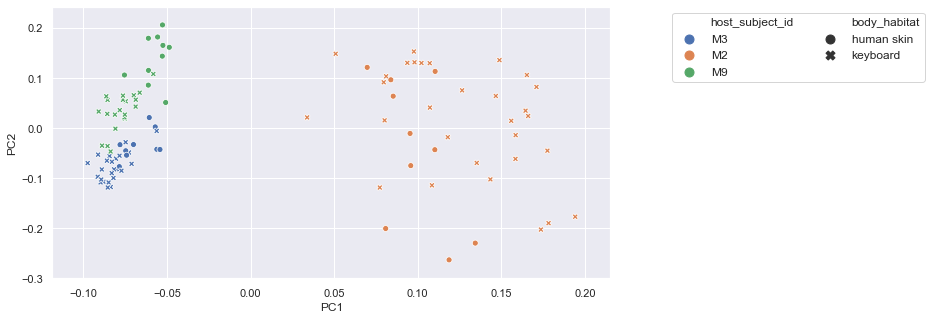

In [18]:
PCAdf_plot = pd.concat([PCAdf, mf], axis=1, sort=False)

fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.scatterplot(x='PC1',y='PC2', hue='host_subject_id',
                style='body_habitat', data=PCAdf_plot, ax=ax)
# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:],
                    prop={'size':12}, loc=2, 
                    bbox_to_anchor=(1.1, 1.0),
                    fancybox=True, framealpha=0.8,ncol=2
                    , markerscale=1.5, facecolor="white")

plt.show()


Now we will run our classification supervised learning on the PC1 & PC2 axis above. 


In [19]:
# specify the model (default)
model = KNeighborsClassifier()
# get test set
test_samples = mf[mf.body_habitat == 'keyboard'].index
X_test = PCAdf.loc[test_samples, :].values
y_test = mf.loc[test_samples, 'host_subject_id'].values
# get train set
train_samples = mf[mf.body_habitat == 'human skin'].index
X_train = PCAdf.loc[train_samples, :].values
y_train = mf.loc[train_samples, 'host_subject_id'].values
# predict using train/test
y_model = model.fit(X_train, y_train).predict(X_test)
# explore the accruacy of the mdoel
accuracy_score(y_test, y_model)


0.8513513513513513

Wow, by reducing the dimensionality with unsupervised learning we actually get better classification accuracy. We can also try the grid search.


In [24]:
# data to fit
X = PCAdf.reindex(mf.index).values
y = mf['host_subject_id'].values

# Create a list where train data human skin indices are -1
# and not human skin(keyboard) validation data indices are 0
split_index = [-1 if x else 0
               for x in mf.body_habitat == 'human skin']

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# grid to search
param_grid = {'n_neighbors': [5, 10, 15, 20, 30],
              'p': [1, 2]}

# Use PredefinedSplit in GridSearchCV
clf = GridSearchCV(estimator = KNeighborsClassifier(),
                   cv=pds,
                   scoring=make_scorer(accuracy_score),
                   param_grid=param_grid)

# Fit with all data
clf.fit(X, y);
# see the best model
clf.best_params_

{'n_neighbors': 5, 'p': 1}

In [25]:
# extract the "best" model
model = clf.best_estimator_
# predict using train/test
y_model = model.fit(X_train, y_train).predict(X_test)
# explore the accruacy of the mdoel
accuracy_score(y_test, y_model)


0.8513513513513513

In this case the grid search does not improve the accuracy because the `best_params_` happen to be the default for the classification. 


Now we can explore what happens as we change parameters in the model - in the classification boundary in PC1/PC2.


In [22]:
# load data
X = PCAdf.reindex(mf.index).values
y = mf['host_subject_id'].values

# encode str to int
encode_ = {'M2':0,'M3':1,'M9':2}
y = [encode_[i] for i in y]

# Training classifiers
n_neighbors_search = [1, 5, 10, 20, 30]
clfs = [KNeighborsClassifier(n_neighbors=i)
        for i in n_neighbors_search]
# fit them all
clfs = [clf.fit(X, y) for clf in clfs]


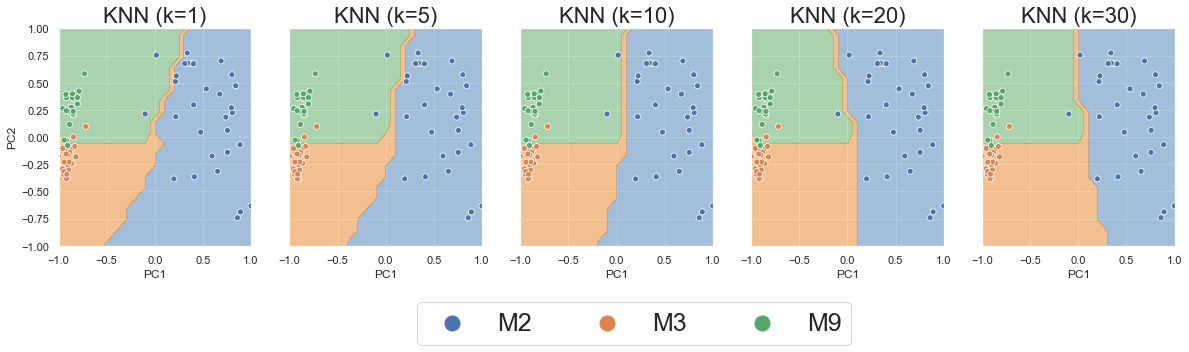

In [30]:
from sklearn.preprocessing import MinMaxScaler

colors = {1:'#377eb8',2:'#ff7f00',3:'#4daf4a'}
 
# Plotting decision regions
scaler = MinMaxScaler((-1,1))
X_plot = scaler.fit_transform(X)
X_plot = pd.concat([pd.DataFrame(X_plot, mf.index), mf], axis=1)
X_plot = X_plot[X_plot.body_habitat == 'keyboard']

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, len(clfs), sharex='col', sharey='row', figsize=(20, 4))

for ax, clf, tt in zip(axarr.flatten(),
                        clfs,
                        ['KNN (k=%i)' % (i)
                         for i in n_neighbors_search]):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z,
                [-1,0,1,2,3],
                alpha=0.4,
                colors=['#377eb8',
                        '#ff7f00',
                        '#4daf4a'])
    sns.scatterplot(x=0,y=1, hue='host_subject_id',
                    style='body_habitat',
                    data=X_plot, ax=ax)
    ax.legend_.remove()
    ax.set_title(tt, fontsize=22)
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')

# add a legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:4], labels[1:4],
                    prop={'size':25}, loc=2, 
                    bbox_to_anchor=(-3.0, -0.20),
                    fancybox=True, framealpha=0.8,ncol=10
                    , markerscale=2.5, facecolor="white")

plt.show()



In the shaded region we can see the boundary where the classifier chooses a subject. From this we can see that as wee increase the number of `n_neighbors` the boundary is more smooth but we begin to overfit on some of the blue samples.  By combining our unsupervised and supervised analysis we gain some ability to visually inspect out classification.